### Imports

In [6]:
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI, max_PI, max_UCB
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF



### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

seed = 42
random.seed(seed)
np.random.seed(seed)

### Ideas
- perform feature selection before running model
- set the initial training set to be informative by choosing same 22 + 80 random as the authors

# Data Prep

### Load Data

In [83]:
data = pd.read_csv('data/DataPool.csv')
print(data.shape)
data.head(5)
cols = data.columns

(1017, 12)


### Split into features and target

In [84]:
X = data.drop(['Yield'],axis=1)
print(X.shape)
y_pool = data['Yield'].to_numpy()
print(y_pool.shape)

(1017, 11)
(1017,)


### Scale data
So all variables have the same mean and std dev

In [85]:
scaler = StandardScaler()
X_pool = scaler.fit_transform(X)

# Define initial dataset
- 11 data points in which each compound is minimized except one is maximized
- 11 data pionts in which each compound is maximized except one is minimized
- 80 random data points

In [10]:
def get_min_max_combinations(ranges_dict, feature):
    
    # min of all other features, max of this feature
    min_combo = []
    for key in ranges_dict.keys():
        
        if key == feature:
            min_combo.append(min(ranges_dict[key]))
        else:
            min_combo.append(max(ranges_dict[key]))
        

    # max of all other features, min of this feature
    max_combo = []
    for key in ranges_dict.keys():
        
        if key == feature:
            max_combo.append(max(ranges_dict[key]))
        else:
            max_combo.append(min(ranges_dict[key]))
    
    return tuple(min_combo), tuple(max_combo)

In [72]:
def get_index(df, combo):
    
    # split into components
    Mg_glutamate, K_glutamate, Amino_Acid, tRNA, coA, NAD, cAMP, Folinic_Acid, Spermidine, Three_PGA, NTP = combo
    
    # get index of matching row in data
    a = df.index[
              np.isclose(df['Mg-glutamate (mM)'], Mg_glutamate) \
            & np.isclose(df['K-glutamate (mM)'], K_glutamate) \
            & np.isclose(df['Amino Acid (mM)'], Amino_Acid) \
            & np.isclose(df['tRNA (mg/ml)'], tRNA) \
            & np.isclose(df['coA (mM)'],coA)  \
            & np.isclose(df['NAD (mM)'], NAD) \
            & np.isclose(df['cAMP (mM)'], cAMP) \
            & np.isclose(df['Folinic Acid (mM)'], Folinic_Acid) \
            & np.isclose(df['Spermidine (mM)'], Spermidine) \
            & np.isclose(df['3-PGA (mM)'], Three_PGA) \
            & np.isclose(df['NTP (mM)'], NTP)]
    return a.tolist()[0]



In [77]:
def get_initial_22_idx(df, ranges_dict):
    
    initial_idx = []
    
    # for each feature
    for key in ranges_dict.keys():
        min_combo, max_combo = get_min_max_combinations(ranges_dict,key)
        idx = get_index(df, min_combo)
        initial_idx.append(idx)
        idx = get_index(df, max_combo)
        initial_idx.append(idx)
        
    return np.array(initial_idx)
    

In [11]:
ranges_dict = {
    'Mg-glutamate (mM)':[0.4,1.2,2,4],
    'K-glutamate (mM)':[8,24,40,80],
    'Amino Acid (mM)': [0.15,0.45,0.75,1.5],
    'tRNA (mg/ml)':[0.02,0.06,0.1,0.2],
    'coA (mM)':[0.026,0.078,0.13,0.26],
    'NAD (mM)':[0.033,0.099,0.165,0.33],
    'cAMP (mM)':[0.075,0.225,0.375,0.75],
    'Folinic Acid (mM)':[0.0068,0.0204,0.034,0.068],
    'Spermidine (mM)':[0.1,0.3,0.5,1],
    '3-PGA (mM)':[3,9,15,30],
    'NTP (mM)':[0.15,0.45,0.75,1.5]
}


In [86]:
idx_first_22 = get_initial_22_idx(data, ranges_dict)

X_training_22 = X_pool[idx_first_22]
y_training_22 = y_pool[idx_first_22]
print(X_training_22.shape)
print(y_training_22.shape)

# remove from pool
X_pool = np.delete(X_pool, idx_first_22, axis=0)
y_pool = np.delete(y_pool, idx_first_22)   
print(X_pool.shape)
print(y_pool.shape)

# chose 80 points from pool at random
idx_random_80 = np.random.choice(range(len(X_pool)), size=80, replace=False)
X_training_80, y_training_80 = X_pool[idx_random_80], y_pool[idx_random_80]
print(X_training_80.shape)
print(y_training_80.shape)

# remove 80 points from pool
X_pool = np.delete(X_pool, idx_random_80, axis=0)
y_pool = np.delete(y_pool, idx_random_80)   
print(X_pool.shape)
print(y_pool.shape) 

# combine training sets together
X_training = np.append(X_training_22, X_training_80, axis=0)
y_training = np.append(y_training_22, y_training_80, axis=0)
print(X_training.shape)
print(y_training.shape)

(22, 11)
(22,)
(995, 11)
(995,)
(80, 11)
(80,)
(915, 11)
(915,)
(102, 11)
(102,)


# Build Bayesian Optimizer
- with Gaussian process
- define the sample space as the data pool. this is an ad-hoc version of membership query synthesis, because we can't draw from any possible point, only the points we have values for.

In [88]:
def get_next_sample(optimizer, X_pool, y_pool):

    # call the query strategy defined in the learner to obtain a new sample
    query_idx, query_sample = optimizer.query(X_pool)

    # modify indexing to interpret as collection of one element with d features
    query_sample_reshaped = query_sample.reshape(1, -1)

    # obtain the query label
    query_label = y_pool[query_idx]

    # modify indexing to interpret as 1D array of one element
    query_label_reshaped = query_label.reshape(1, )

    return query_sample_reshaped, query_label_reshaped, query_idx


In [89]:
def get_next_batch(optimizer, X_pool, y_pool, batch_size):
    
    n_col = X_pool.shape[1]
    X_batch = np.zeros((batch_size, n_col))
    y_batch = np.zeros((batch_size,))

    
    for i in range(batch_size):
        
        X_sample, y_sample, query_idx = get_next_sample(optimizer, X_pool, y_pool)
        
        # add to batch
        X_batch[i] = X_sample
        y_batch[i] = y_sample
        
        # remove queried point from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)     
        
    return X_batch, y_batch, X_pool, y_pool
        


In [90]:
def run_bayesian_optimization(optimizer, X_pool, y_pool, n_batch, batch_size, initial):
    
    selected = [initial]
    for b in range(n_batch):
        
        # get next set of points to learn
        X_batch, y_batch, X_pool, y_pool = get_next_batch(optimizer, X_pool, y_pool, batch_size)
#         print(X_batch.shape)
#         print(y_batch.shape)
#         print('X_pool size, y_pool size', X_pool.shape, y_pool.shape)
        
        # save data
        batch_col = np.array([b]*len(X_batch)).reshape(-1,1)
        y_col = y_batch.reshape(-1,1)
        result = np.append(X_batch,y_col, axis=1)
        selected.append(result)
    
        # use new sample to update the model
        optimizer.teach(X_batch, y_batch)
        
        # score results
#         print('score results for batch ', b)
    
    return selected

# Run model
?? Does initial training set count among total query number of 510?
- random initial training set

In [93]:
%%time 
# 15 min

# copy data for this section
X_cp = copy.deepcopy(X_pool)
y_cp = copy.deepcopy(y_pool)

# define optimizer
kernel = Matern(1.0) 
optimizer = BayesianOptimizer(
    estimator=GaussianProcessRegressor(kernel=kernel),
    X_training=X_training, 
    y_training=y_training,
    query_strategy=max_EI
)

# save initial training data as first batch
initial = np.append(X_training, y_training.reshape(-1,1),axis=1)

# Bayesian optimization
n_batch = 4
batch_size = 102
selected = run_bayesian_optimization(optimizer, X_cp, y_cp, n_batch, batch_size, initial)



CPU times: user 12.3 s, sys: 380 ms, total: 12.7 s
Wall time: 3.39 s


# Results
- Selected points
?? how do they define how much yield has improved? what is the starting yield?

In [149]:
def build_results_dataframe(selected, cols):
    
    # empty dataframe with correct column number
    df = pd.DataFrame(columns=cols)
    
    for i,each in enumerate(selected):
        
        # create rows
        df_i = pd.DataFrame(each, columns=cols)
        
        # add col for batch
        df_i['Batch'] = i
        
        # append to final dataframe
        df = df.append(df_i)
        
    return df
        

In [163]:
def yield_stats(df, batch):
    """
    Average yield and min and max yield.
    """
    
    df_yield = df[df['Batch']==batch]['Yield']
    
    # mean
    mean_yield = df_yield.mean()
    
    # std dev
    std_yield = df_yield.std()
    
    # min
    min_yield = df_yield.min()
    
    # max
    max_yield = df_yield.max()
    
    return mean_yield, std_yield, min_yield, max_yield
    

In [205]:
df_results = build_results_dataframe(selected, cols.tolist())
df_results

,Mg-glutamate (mM),K-glutamate (mM),Amino Acid (mM),tRNA (mg/ml),coA (mM),NAD (mM),cAMP (mM),Folinic Acid (mM),Spermidine (mM),3-PGA (mM),NTP (mM),Yield,Batch
0,-0.638449,-1.414753,0.322945,-0.981173,-0.792611,-0.900332,1.781938,-1.104683,0.164205,1.057689,-0.777751,8.326,0.0
1,0.946763,0.923136,-0.280242,2.177701,1.036283,-0.175362,-0.533273,0.386309,-0.696601,-0.251708,0.933571,20.632,0.0
2,0.946763,0.923136,-0.883429,0.422771,0.121836,-0.900332,-0.533273,2.250049,1.025011,-0.251708,0.933571,11.405,0.0
3,0.946763,0.923136,-0.883429,-0.981173,-0.792611,0.549609,0.624333,2.250049,1.025011,-0.251708,0.933571,14.025,0.0
4,-1.272534,-0.746785,-0.280242,-0.981173,-0.792611,-0.900332,-0.533273,0.386309,1.025011,-0.251708,-0.777751,11.328,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.946763,0.923136,-0.883429,-0.981173,0.121836,0.549609,-0.533273,0.386309,0.164205,-0.251708,0.933571,19.521,50.0
1,0.946763,0.923136,-0.883429,-0.981173,-0.792611,0.549609,-0.533273,-1.104683,0.164205,-0.251708,0.933571,16.957,50.0
2,0.946763,0.923136,-0.280242,-0.279201,-0.792611,0.549609,-0.533273,0.386309,1.025011,-0.251708,0.933571,13.485,50.0
3,0.946763,0.923136,-0.280242,-0.279201,-0.792611,-0.900332,0.624333,0.386309,0.164205,-0.251708,0.933571,19.658,50.0


In [206]:
mean_yields = [] 
std_yields = []
min_yields = []
max_yields = []

for b in range(n_batch):
    mean_yield, std_yield, min_yield, max_yield = yield_stats(df_results, b)
    
    mean_yields.append(mean_yield)
    std_yields.append(std_yield)
    min_yields.append(min_yield)
    max_yields.append(max_yield)

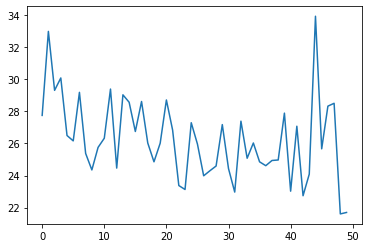

In [207]:
plt.plot(max_yields)